<a href="https://colab.research.google.com/github/RayGone/SentimentAnalysis/blob/phase1/Experiments/Transformer2SVM_4SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers tokenizers datasets huggingface_hub --quiet

import numpy as np
import random
import os
import tensorflow as tf
from transformers import set_seed

rand_seed = 9

def seed_everything(seed=0):
    random.seed(seed) # random
    os.environ['PYTHONHASHSEED'] = str(seed) # python enviroment
    np.random.seed(seed) # numpy
    tf.keras.utils.set_random_seed(seed) # tensorflow
    tf.random.set_seed(seed) # tensorflow
    set_seed(seed) # hugging_face transformer

seed_everything(rand_seed)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 37.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.5 MB/s eta 0:00:00


In [2]:
from transformers import PreTrainedTokenizerFast, BertTokenizerFast, TFAutoModel
import datasets

# gptModel = 'raygx/Nepali-GPT2-CausalLM'
# gptTokenizer = PreTrainedTokenizerFast.from_pretrained(gptModel,padding_side='left')
# gptModel = TFAutoModel.from_pretrained(gptModel)

bertModel = 'Shushant/nepaliBERT'
bertTokenizer = BertTokenizerFast.from_pretrained(bertModel)
bertModel = TFAutoModel.from_pretrained(bertModel,from_pt=True)

bertModel.config

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at raygx/Nepali-GPT2-CausalLM.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'bert.embeddings.position_ids', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

(GPT2Config {
   "_name_or_path": "raygx/Nepali-GPT2-CausalLM",
   "activation_function": "gelu_new",
   "architectures": [
     "GPT2LMHeadModel"
   ],
   "attn_pdrop": 0.1,
   "bos_token_id": 1,
   "embd_pdrop": 0.1,
   "eos_token_id": 2,
   "initializer_range": 0.02,
   "layer_norm_epsilon": 1e-05,
   "model_type": "gpt2",
   "n_ctx": 1024,
   "n_embd": 768,
   "n_head": 12,
   "n_inner": null,
   "n_layer": 12,
   "n_positions": 1024,
   "pad_token_id": 3,
   "reorder_and_upcast_attn": false,
   "resid_pdrop": 0.1,
   "scale_attn_by_inverse_layer_idx": false,
   "scale_attn_weights": true,
   "summary_activation": null,
   "summary_first_dropout": 0.1,
   "summary_proj_to_labels": true,
   "summary_type": "cls_index",
   "summary_use_proj": true,
   "task_specific_params": {
     "text-generation": {
       "do_sample": true,
       "max_length": 50
     }
   },
   "transformers_version": "4.30.2",
   "use_cache": true,
   "vocab_size": 50000
 },
 BertConfig {
   "_name_or_path": "

In [3]:
print("#######################Using NepCov19Tweets#########################")
data = datasets.load_dataset("raygx/NepCov19TweetsPlus")

data = data.rename_columns({"Sentiment":"label","Sentences":"text"})
data

#######################Using NepCov19Tweets#########################


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/41541 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/raygx___parquet/raygx--NepCov19TweetsPlus-46f98dd56864ead2/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 41541
    })
})

In [4]:
data = data.shuffle(rand_seed)
data = data['train'].train_test_split(test_size=0.2)
data

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [5]:
def prepareLabels(row):
    if row['label'] == -1:
        row['label'] = 2

    return row

data = data.map(
        prepareLabels,
        num_proc=4)

data

Map (num_proc=4):   0%|          | 0/33232 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/8309 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 33232
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 8309
    })
})

In [6]:
import tensorflow as tf

# class GPTEmbedding(tf.keras.layers.Layer):
#   def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
#     super().__init__()
#     self.embedding = model
#     self.tokenizer = tokenizer
#     self.tokenizer.padding_side = 'left'
#     self.max_token = max_token_len
#     self.padding = padding
#     self.truncation = truncation
#     self.trainable=False

#   def call(self, x):
#     embeddings = self.embedding(
#                   self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf')
#                 )[0][:,-4:,:]

#     return tf.reduce_logsumexp(embeddings,axis=1) * 0.1

class BERTEmbedding(tf.keras.layers.Layer):
  def __init__(self, model,tokenizer, max_token_len=128,padding='max_length',truncation=True):
    super().__init__()
    self.embedding = model
    self.tokenizer = tokenizer
    self.max_token = max_token_len
    self.padding = padding
    self.truncation = truncation
    self.trainable=False

  def call(self, x):
    return self.embedding(self.tokenizer(x,padding=self.padding,truncation=self.truncation,max_length=self.max_token,return_tensors='tf'))[1]

### Preparing Training Data

In [40]:
from tqdm.auto import tqdm

bertEmbd = BERTEmbedding(model=bertModel,tokenizer=bertTokenizer)
max_pool = tf.keras.layers.AveragePooling1D(pool_size=4)

X = None

batch = 32
for i in tqdm(range(0,data['train'].num_rows,batch)):
    feat = bertEmbd(data['train'][i:i+batch]['text'])
    feat = max_pool(tf.reshape(feat, [feat.shape[0],feat.shape[1],1] ))
    feat = tf.reshape(feat, [feat.shape[0],feat.shape[1]])

    if i==0:
        X = feat
    else:
        X = np.concatenate([X,feat],axis=0)


  0%|          | 0/1039 [00:00<?, ?it/s]

## Training

In [41]:
%%time
from sklearn import svm

y = data['train']['label']
clf = svm.SVC()  ## default 'rbf'
clf.fit(X, y)
clf.classes_

CPU times: user 2min 32s, sys: 203 ms, total: 2min 32s
Wall time: 2min 32s


array([0, 1, 2])

### Preparing Test Data

In [42]:
testX = None

batch = 32
for i in tqdm(range(0,data['test'].num_rows,batch)):
    feat = bertEmbd(data['test'][i:i+batch]['text'])
    feat = max_pool(tf.reshape(feat, [feat.shape[0],feat.shape[1],1] ))
    feat = tf.reshape(feat, [feat.shape[0],feat.shape[1]])

    if i==0:
        testX = feat
    else:
        testX = np.concatenate([testX,feat],axis=0)

  0%|          | 0/260 [00:00<?, ?it/s]

## Evaluation

In [43]:
%%time
predictions = clf.predict(testX)

CPU times: user 46.7 s, sys: 56 ms, total: 46.8 s
Wall time: 46.7 s


In [44]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

y = data['test']['label']
print("F1-Score",f1_score(np.array(y),predictions,average='weighted'))
print("Precision-Score",precision_score(np.array(y),predictions,average='weighted'))
print("Recall-Score",recall_score(np.array(y),predictions,average='weighted'))
print("accuracy_Score",accuracy_score(np.array(y),predictions))

F1-Score 0.7054666269088776
Precision-Score 0.7076136308859112
Recall-Score 0.7061018173065351
accuracy_Score 0.7061018173065351


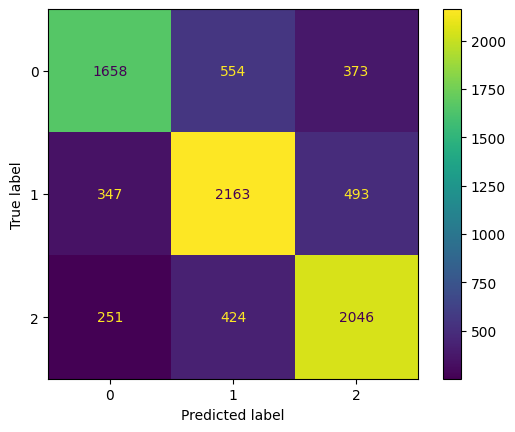

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(tf.math.confusion_matrix(np.array(y),predictions,num_classes=3).numpy())
cmd.plot()